# **Cellule 1 — Imports & config**

In [1]:
# PREPROCESSING LLM PREFERENCES - KAGGLE CHATBOT ARENA

import os
import ast
import pickle
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Style des graphiques
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 10

print("✅ Imports OK")
print("📅", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

✅ Imports OK
📅 2025-12-10 15:13:20


# **Cellule 2 — Chemins du projet**

In [2]:
import os
import sys

# === Détection Colab ===
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("📌 Exécution dans Google Colab")
    BASE_DIR = "/content/projet_llm"
else:
    print("📌 Exécution en local")
    BASE_DIR = os.getcwd()  # chemin du projet sur ton PC

DATA_DIR = os.path.join(BASE_DIR, "data")
PROCESSOR_DIR = os.path.join(BASE_DIR, "notebooks", "processors")

# Création des dossiers
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PROCESSOR_DIR, exist_ok=True)

print("📂 BASE_DIR      :", BASE_DIR)
print("📂 DATA_DIR      :", DATA_DIR)
print("📂 PROCESSOR_DIR :", PROCESSOR_DIR)


📌 Exécution dans Google Colab
📂 BASE_DIR      : /content/projet_llm
📂 DATA_DIR      : /content/projet_llm/data
📂 PROCESSOR_DIR : /content/projet_llm/notebooks/processors


# **Cellule 3 — Chargement des données brutes**

In [3]:
# === Upload du fichier train.csv depuis ton PC ===
from google.colab import files

print("📤 Veuillez uploader train.csv depuis votre ordinateur...")
uploaded = files.upload()

# Récupération du nom du fichier uploadé
uploaded_filename = list(uploaded.keys())[0]
print("📥 Fichier reçu :", uploaded_filename)

# Déplacement dans /content/projet_llm/data/
DEST_PATH = os.path.join(DATA_DIR, "train.csv")
!mv "{uploaded_filename}" "{DEST_PATH}"

print("📦 train.csv déplacé vers :", DEST_PATH)

# Chargement du CSV
df = pd.read_csv(DEST_PATH)
print("✅ Train chargé :", df.shape)
df.head()


📤 Veuillez uploader train.csv depuis votre ordinateur...


Saving train (1).csv to train (1).csv
📥 Fichier reçu : train (1).csv
📦 train.csv déplacé vers : /content/projet_llm/data/train.csv
✅ Train chargé : (57477, 9)


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
0,30192,gpt-4-1106-preview,gpt-4-0613,"[""Is it morally right to try to have a certain...","[""The question of whether it is morally right ...","[""As an AI, I don't have personal beliefs or o...",1,0,0
1,53567,koala-13b,gpt-4-0613,"[""What is the difference between marriage lice...","[""A marriage license is a legal document that ...","[""A marriage license and a marriage certificat...",0,1,0
2,65089,gpt-3.5-turbo-0613,mistral-medium,"[""explain function calling. how would you call...","[""Function calling is the process of invoking ...","[""Function calling is the process of invoking ...",0,0,1
3,96401,llama-2-13b-chat,mistral-7b-instruct,"[""How can I create a test set for a very rare ...","[""Creating a test set for a very rare category...","[""When building a classifier for a very rare c...",1,0,0
4,198779,koala-13b,gpt-3.5-turbo-0314,"[""What is the best way to travel from Tel-Aviv...","[""The best way to travel from Tel Aviv to Jeru...","[""The best way to travel from Tel-Aviv to Jeru...",0,1,0


# **Cellule 4 — Inspection rapide & valeurs manquantes**

In [4]:
print("Colonnes :", df.columns.tolist())

print("\nTypes :")
print(df.dtypes)

print("\nPourcentage de valeurs manquantes par colonne :")
print((df.isna().mean() * 100).round(2).sort_values(ascending=False))

df.sample(3, random_state=42)

Colonnes : ['id', 'model_a', 'model_b', 'prompt', 'response_a', 'response_b', 'winner_model_a', 'winner_model_b', 'winner_tie']

Types :
id                 int64
model_a           object
model_b           object
prompt            object
response_a        object
response_b        object
winner_model_a     int64
winner_model_b     int64
winner_tie         int64
dtype: object

Pourcentage de valeurs manquantes par colonne :
id                0.0
model_a           0.0
model_b           0.0
prompt            0.0
response_a        0.0
response_b        0.0
winner_model_a    0.0
winner_model_b    0.0
winner_tie        0.0
dtype: float64


,id,model_a,model_b,prompt,response_a,response_b,winner_model_a,winner_model_b,winner_tie
37379,2785062085,gpt-3.5-turbo-0613,codellama-34b-instruct,"[""what does hello world mean""]","[""\""Hello, World!\"" is a phrase used in comput...","[""\""Hello, World!\"" is a common phrase used to...",1,0,0
644,48259531,mistral-medium,gpt-4-0314,"[""I ran a marathon in 3:12:00 weighting 84kg. ...","[""It's difficult to provide an exact answer to...","[""To accurately estimate how much faster you w...",1,0,0
48496,3622731894,gpt-4-0314,gpt-3.5-turbo-0314,"[""Below is an instruction that describes a tas...","[""\u8fd9\u6b3e\u7eaf\u8272\u4e94\u5206\u88e4\u...","[""\u6839\u636e\u63d0\u4f9b\u7684\u4ea7\u54c1\u...",0,0,1


# **Cellule 5 — Nettoyage des champs texte (listes → texte continu)**

In [5]:
def clean_text_field(x):
    """
    Transforme :
      - string représentant une liste: "[...]"  -> concaténation des éléments
      - vraie liste Python:             [...]   -> concaténation
      - string simple:                          -> strip
    """
    # Cas 1 : déjà une liste Python
    if isinstance(x, list):
        return " ".join([str(t) for t in x])

    # Cas 2 : string
    if isinstance(x, str):
        s = x.strip()

        # Si ça ressemble à une liste => on essaie de parser
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list):
                    return " ".join([str(t) for t in parsed])
            except Exception:
                # parsing échoué => on garde tel quel
                pass

        return s

    # Fallback
    return str(x)


for col in ["prompt", "response_a", "response_b"]:
    if col in df.columns:
        df[col] = df[col].fillna("").apply(clean_text_field)

df[["prompt", "response_a", "response_b"]].head(3)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:1: SyntaxWarning: invalid escape sequence '\/'
<unknown>:

,prompt,response_a,response_b
0,Is it morally right to try to have a certain p...,The question of whether it is morally right to...,"As an AI, I don't have personal beliefs or opi..."
1,What is the difference between marriage licens...,A marriage license is a legal document that al...,A marriage license and a marriage certificate ...
2,explain function calling. how would you call a...,Function calling is the process of invoking or...,Function calling is the process of invoking a ...


# **Cellule 6 — Création de la cible winner (A gagne / B gagne / tie)**

In [6]:
def compute_winner(row):
    # 1 si A gagne, 0 si B gagne, -1 si égalité ou cible manquante
    if row.get("winner_model_a", 0) == 1:
        return 1
    elif row.get("winner_model_b", 0) == 1:
        return 0
    elif row.get("winner_tie", 0) == 1:
        return -1
    else:
        return -1

df["winner"] = df.apply(compute_winner, axis=1)

print("Distribution winner (avec ties et cas bizarres) :")
print(df["winner"].value_counts(dropna=False))


Distribution winner (avec ties et cas bizarres) :
winner
 1    20064
 0    19652
-1    17761
Name: count, dtype: int64


# **Cellule 7 — Suppression des ties et vérification distribution cible**

In [7]:
df = df[df["winner"] != -1].copy()
df["winner"] = df["winner"].astype(int)

print("Après suppression des ties :")
print(df["winner"].value_counts())
print("\nProportions :")
print((df["winner"].value_counts(normalize=True) * 100).round(2))


Après suppression des ties :
winner
1    20064
0    19652
Name: count, dtype: int64

Proportions :
winner
1    50.52
0    49.48
Name: proportion, dtype: float64


# **Cellule 8 — Visualisation distribution de la cible**

/tmp/ipython-input-2451133356.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Model B wins (0)", "Model A wins (1)"])


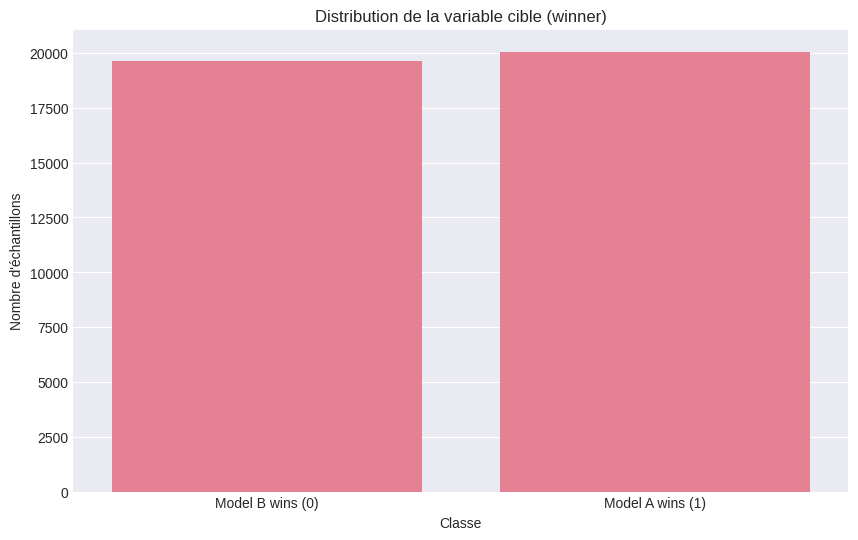

In [8]:
fig, ax = plt.subplots()
sns.countplot(x=df["winner"], ax=ax)
ax.set_xticklabels(["Model B wins (0)", "Model A wins (1)"])
ax.set_title("Distribution de la variable cible (winner)")
ax.set_xlabel("Classe")
ax.set_ylabel("Nombre d'échantillons")
plt.show()


# **Cellule 9 — Feature engineering simple (pour EDA)**

In [9]:
df["len_prompt"] = df["prompt"].str.len()
df["len_a"] = df["response_a"].str.len()
df["len_b"] = df["response_b"].str.len()

df["tokens_prompt"] = df["prompt"].str.split().apply(len)
df["tokens_a"] = df["response_a"].str.split().apply(len)
df["tokens_b"] = df["response_b"].str.split().apply(len)

df["diff_len_ab"] = df["len_a"] - df["len_b"]
df["diff_tokens_ab"] = df["tokens_a"] - df["tokens_b"]

df[["len_prompt", "len_a", "len_b", "tokens_a", "tokens_b", "diff_len_ab"]].describe().T


,count,mean,std,min,25%,50%,75%,max
len_prompt,39716.0,345.383347,1023.166884,3.0,47.0,89.0,224.25,32839.0
len_a,39716.0,1383.481217,1503.445471,0.0,430.0,1100.0,1862.00,53299.0
len_b,39716.0,1391.123351,1508.577382,0.0,437.0,1106.0,1873.00,45563.0
tokens_a,39716.0,220.087119,232.552102,0.0,72.0,179.0,298.00,9184.0
tokens_b,39716.0,221.063904,231.700647,0.0,73.0,180.0,298.00,6893.0
diff_len_ab,39716.0,-7.642134,1116.847170,-19863.0,-471.0,0.0,454.00,42783.0


# **Cellule 10 — Visualisation des longueurs de texte**

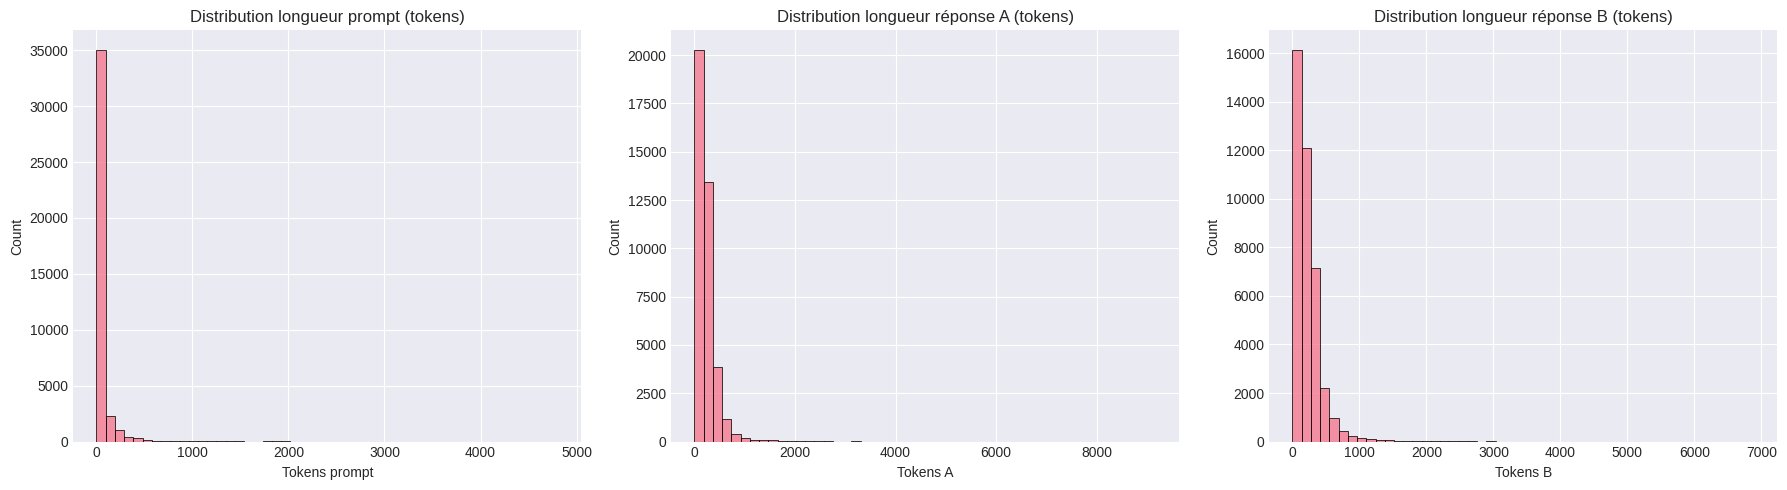

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df["tokens_prompt"], bins=50, ax=axes[0])
axes[0].set_title("Distribution longueur prompt (tokens)")
axes[0].set_xlabel("Tokens prompt")

sns.histplot(df["tokens_a"], bins=50, ax=axes[1])
axes[1].set_title("Distribution longueur réponse A (tokens)")
axes[1].set_xlabel("Tokens A")

sns.histplot(df["tokens_b"], bins=50, ax=axes[2])
axes[2].set_title("Distribution longueur réponse B (tokens)")
axes[2].set_xlabel("Tokens B")

plt.tight_layout()
plt.show()


# **Cellule 11 — Longueurs vs cible (visualisation nouvelles features)**

/tmp/ipython-input-1445543961.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["B wins (0)", "A wins (1)"])
/tmp/ipython-input-1445543961.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["B wins (0)", "A wins (1)"])


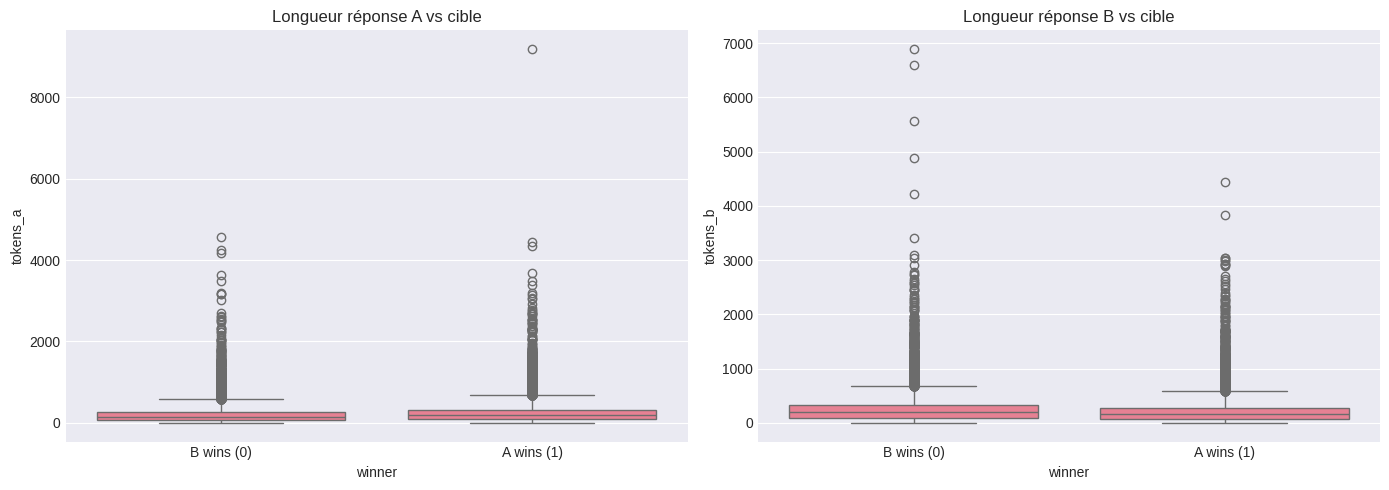

/tmp/ipython-input-1445543961.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["B wins (0)", "A wins (1)"])


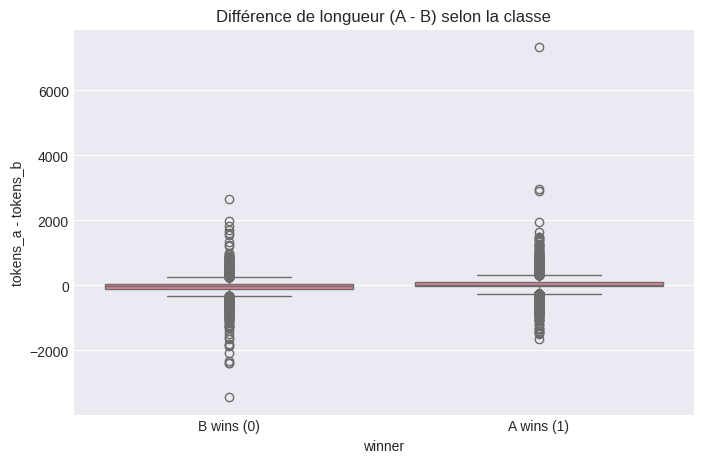

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x="winner", y="tokens_a", data=df, ax=axes[0])
axes[0].set_xticklabels(["B wins (0)", "A wins (1)"])
axes[0].set_title("Longueur réponse A vs cible")

sns.boxplot(x="winner", y="tokens_b", data=df, ax=axes[1])
axes[1].set_xticklabels(["B wins (0)", "A wins (1)"])
axes[1].set_title("Longueur réponse B vs cible")

plt.tight_layout()
plt.show()

# Différence de longueur entre A et B
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x="winner", y="diff_tokens_ab", data=df, ax=ax)
ax.set_xticklabels(["B wins (0)", "A wins (1)"])
ax.set_title("Différence de longueur (A - B) selon la classe")
ax.set_ylabel("tokens_a - tokens_b")
plt.show()


# **Cellule 12 — Construction de la feature texte finale**

In [12]:
df["text"] = (
    "MODEL_A: " + df["model_a"].astype(str) +
    " MODEL_B: " + df["model_b"].astype(str) +
    " PROMPT: " + df["prompt"].fillna("") +
    " RESPONSE_A: " + df["response_a"].fillna("") +
    " RESPONSE_B: " + df["response_b"].fillna("")
)

df[["text", "winner"]].head(3)


,text,winner
0,MODEL_A: gpt-4-1106-preview MODEL_B: gpt-4-061...,1
1,MODEL_A: koala-13b MODEL_B: gpt-4-0613 PROMPT:...,0
3,MODEL_A: llama-2-13b-chat MODEL_B: mistral-7b-...,1


# **Cellule 13 — Split train / test (stratifié) + vérification des distributions**

In [13]:
X_text = df["text"]
y = df["winner"]

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Taille X_train_text :", X_train_text.shape[0])
print("Taille X_test_text  :", X_test_text.shape[0])

print("\nDistribution y_train :")
print((y_train.value_counts(normalize=True) * 100).round(2))

print("\nDistribution y_test :")
print((y_test.value_counts(normalize=True) * 100).round(2))


Taille X_train_text : 31772
Taille X_test_text  : 7944

Distribution y_train :
winner
1    50.52
0    49.48
Name: proportion, dtype: float64

Distribution y_test :
winner
1    50.52
0    49.48
Name: proportion, dtype: float64


# **Cellule 14 — Visualisation de la distribution cible (train vs test)**

/tmp/ipython-input-297698414.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["B wins (0)", "A wins (1)"])
/tmp/ipython-input-297698414.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(["B wins (0)", "A wins (1)"])


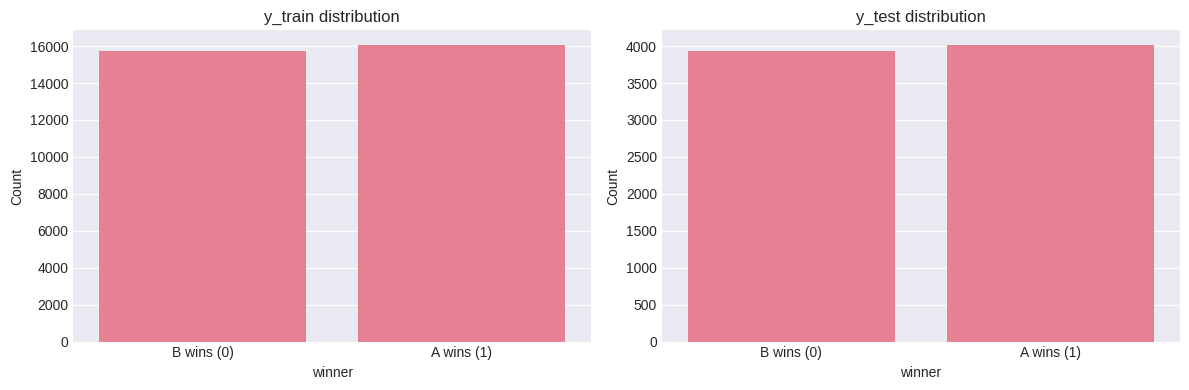

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=y_train, ax=axes[0])
axes[0].set_title("y_train distribution")
axes[0].set_xticklabels(["B wins (0)", "A wins (1)"])
axes[0].set_ylabel("Count")

sns.countplot(x=y_test, ax=axes[1])
axes[1].set_title("y_test distribution")
axes[1].set_xticklabels(["B wins (0)", "A wins (1)"])
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


# **Cellule 15 — TF-IDF (configuration RAM-friendly)**

In [15]:
vectorizer = TfidfVectorizer(
    max_features=50_000,   # tu peux augmenter si tu as plus de RAM (ex: 100_000)
    ngram_range=(1, 1),    # unigrams; on pourra tester (1,2) plus tard
    stop_words="english",
    min_df=3               # ignore les tokens trop rares
)

print("🔄 Fit du TF-IDF sur X_train_text...")
X_train = vectorizer.fit_transform(X_train_text)
X_test = vectorizer.transform(X_test_text)

print("✅ TF-IDF terminé")
print("Shape X_train:", X_train.shape)
print("Shape X_test :", X_test.shape)


🔄 Fit du TF-IDF sur X_train_text...
✅ TF-IDF terminé
Shape X_train: (31772, 50000)
Shape X_test : (7944, 50000)


# **Cellule 16 — Sauvegarde des artifacts de preprocessing**

In [16]:
preprocessed_data = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test
}

preprocessed_path = os.path.join(PROCESSOR_DIR, "preprocessed_data.pkl")
vectorizer_path = os.path.join(PROCESSOR_DIR, "vectorizer.pkl")
feature_names_path = os.path.join(PROCESSOR_DIR, "feature_names.pkl")
smote_config_path = os.path.join(PROCESSOR_DIR, "smote_config.pkl")

with open(preprocessed_path, "wb") as f:
    pickle.dump(preprocessed_data, f)

with open(vectorizer_path, "wb") as f:
    pickle.dump(vectorizer, f)

feature_names = vectorizer.get_feature_names_out()
with open(feature_names_path, "wb") as f:
    pickle.dump(feature_names, f)

smote_config = {
    "used": False,
    "comment": "No SMOTE applied: text data + classes relativement équilibrées."
}
with open(smote_config_path, "wb") as f:
    pickle.dump(smote_config, f)

print("✅ preprocessed_data.pkl  →", preprocessed_path)
print("✅ vectorizer.pkl        →", vectorizer_path)
print("✅ feature_names.pkl     →", feature_names_path)
print("✅ smote_config.pkl      →", smote_config_path)


✅ preprocessed_data.pkl  → /content/projet_llm/notebooks/processors/preprocessed_data.pkl
✅ vectorizer.pkl        → /content/projet_llm/notebooks/processors/vectorizer.pkl
✅ feature_names.pkl     → /content/projet_llm/notebooks/processors/feature_names.pkl
✅ smote_config.pkl      → /content/projet_llm/notebooks/processors/smote_config.pkl


# **Cellule 17 — Vérification de rechargement (sanity check)**

In [17]:
with open(preprocessed_path, "rb") as f:
    data_loaded = pickle.load(f)

print("Shapes rechargées :")
print("X_train:", data_loaded["X_train"].shape)
print("X_test :", data_loaded["X_test"].shape)
print("y_train:", data_loaded["y_train"].shape)
print("y_test :", data_loaded["y_test"].shape)

with open(vectorizer_path, "rb") as f:
    vec_loaded = pickle.load(f)

print("\nNombre de features TF-IDF :", len(vec_loaded.get_feature_names_out()))


Shapes rechargées :
X_train: (31772, 50000)
X_test : (7944, 50000)
y_train: (31772,)
y_test : (7944,)

Nombre de features TF-IDF : 50000


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
# === Sauvegarde du projet complet dans Google Drive ===

# Monter Google Drive si ce n'est pas déjà fait
from google.colab import drive
drive.mount('/content/drive')

# Chemin du projet
PROJECT_DIR = "/content/projet_llm"

# Nom et emplacement du zip dans /content
ZIP_PATH = "/content/projet_llm.zip"

print("📦 Zippage du projet...")
!zip -r "{ZIP_PATH}" "{PROJECT_DIR}"

# Copier le zip dans Google Drive
DEST_DRIVE_PATH = "/content/drive/MyDrive/projet_llm.zip"
!cp "{ZIP_PATH}" "{DEST_DRIVE_PATH}"

print("🎉 All done! ZIP saved to Google Drive →", DEST_DRIVE_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Zippage du projet...
  adding: content/projet_llm/ (stored 0%)
  adding: content/projet_llm/data/ (stored 0%)
  adding: content/projet_llm/data/train.csv (deflated 68%)
  adding: content/projet_llm/notebooks/ (stored 0%)
  adding: content/projet_llm/notebooks/processors/ (stored 0%)
  adding: content/projet_llm/notebooks/processors/vectorizer.pkl (deflated 70%)
  adding: content/projet_llm/notebooks/processors/smote_config.pkl (deflated 4%)
  adding: content/projet_llm/notebooks/processors/feature_names.pkl (deflated 64%)
  adding: content/projet_llm/notebooks/processors/preprocessed_data.pkl (deflated 24%)
🎉 All done! ZIP saved to Google Drive → /content/drive/MyDrive/projet_llm.zip
